In [1]:
import re

file_path = "amazon-meta.txt"

#store parsed data
items = []
similar_items = []
categories = []
reviews = []

#parse
def parse_categories(line):
    categories = []
    for part in line.split("|"):
        if part:  # Avoid empty strings
            category_name = part.split("[")[0].strip()
            categories.append(category_name)
    return categories
def parse_review_line(line):
    match = re.match(r"(\d{4}-\d{1,2}-\d{1,2})\s+cutomer:\s+(\S+)\s+rating:\s+(\d+)\s+votes:\s+(\d+)\s+helpful:\s+(\d+)", line)
    if match:
        return {
            "Date": match.group(1),
            "CustomerId": match.group(2),
            "Rating": int(match.group(3)),
            "Votes": int(match.group(4)),
            "Helpful": int(match.group(5)),
        }
    return None

# reading and parsing file
with open(file_path, "r") as file:
    current_item = None
    for line in file:
        line = line.strip()

        if line.startswith("Id:"):
            if current_item: 
                items.append(current_item)
            current_item = {"Id": int(line.split(":")[1].strip()), "Similar": [], "Categories": [], "Reviews": []}

        elif line.startswith("ASIN:"):
            current_item["ASIN"] = line.split(":")[1].strip()

        elif line.startswith("title:"):
            current_item["Title"] = line.split("title:")[1].strip()

        elif line.startswith("group:"):
            current_item["Group"] = line.split("group:")[1].strip()

        elif line.startswith("salesrank:"):
            current_item["SalesRank"] = int(line.split("salesrank:")[1].strip())

        elif line.startswith("similar:"):
            similar_asins = line.split()[2:] 
            current_item["Similar"] = similar_asins

        elif line.startswith("categories:"):
            pass  #placeholder

        elif re.match(r"\|", line):  #category line starts with "|"
            current_item["Categories"].extend(parse_categories(line))

        elif line.startswith("reviews:"):
            pass  #skip for now

        elif re.match(r"\d{4}-\d{1,2}-\d{1,2}", line):  
            review = parse_review_line(line)
            if review:
                current_item["Reviews"].append(review)

        elif line.startswith("discontinued product"):
            current_item = None

    if current_item:
        items.append(current_item)

#organize data
for item in items:
    item_id = item["Id"]
    for sim in item["Similar"]:
        similar_items.append((item_id, sim))
    for category in item["Categories"]:
        categories.append((item_id, category))
    for review in item["Reviews"]:
        reviews.append((item_id, review["CustomerId"], review["Rating"], review["Votes"], review["Helpful"]))

In [2]:
import sqlite3

#connect to database
conn = sqlite3.connect("amazon_items.db")
cursor = conn.cursor()

#create tables
cursor.execute("""
CREATE TABLE Items (
    ItemId INTEGER PRIMARY KEY,
    ASIN TEXT UNIQUE,
    Title TEXT,
    GroupName TEXT,
    SalesRank INTEGER
)""")

cursor.execute("""
CREATE TABLE SimilarItems (
    ItemId INTEGER,
    SimilarItemId TEXT,
    FOREIGN KEY (ItemId) REFERENCES Items(ItemId)
)""")

cursor.execute("""
CREATE TABLE Categories (
    CategoryId INTEGER PRIMARY KEY AUTOINCREMENT,
    ItemId INTEGER,
    CategoryName TEXT,
    FOREIGN KEY (ItemId) REFERENCES Items(ItemId)
)""")

cursor.execute("""
CREATE TABLE Reviews (
    ReviewId INTEGER PRIMARY KEY AUTOINCREMENT,
    ItemId INTEGER,
    CustomerId TEXT,
    Rating INTEGER,
    Votes INTEGER,
    Helpful INTEGER,
    FOREIGN KEY (ItemId) REFERENCES Items(ItemId)
)""")

#insert data!
cursor.executemany("INSERT INTO Items (ItemId, ASIN, Title, GroupName, SalesRank) VALUES (?, ?, ?, ?, ?)",
                   [(item["Id"], item["ASIN"], item.get("Title"), item.get("Group"), item.get("SalesRank")) for item in items])

cursor.executemany("INSERT INTO SimilarItems (ItemId, SimilarItemId) VALUES (?, ?)", similar_items)
cursor.executemany("INSERT INTO Categories (ItemId, CategoryName) VALUES (?, ?)", categories)
cursor.executemany("INSERT INTO Reviews (ItemId, CustomerId, Rating, Votes, Helpful) VALUES (?, ?, ?, ?, ?)", reviews)

conn.commit()
conn.close()

In [3]:
conn = sqlite3.connect("amazon_items.db")
cursor = conn.cursor()

def print_table(table_name):
    print(f"--- {table_name} (First 5 Rows) ---")
    cursor.execute(f"SELECT * FROM {table_name} LIMIT 15")  
    rows = cursor.fetchall()
    if rows:
        for row in rows:
            print(row)
    else:
        print("No data found.")
    print()

#print the first 15 rows of these tables
tables = ["Items", "SimilarItems", "Categories", "Reviews"]
for table in tables:
    print_table(table)

conn.close()

--- Items (First 5 Rows) ---
(1, '0827229534', 'Patterns of Preaching: A Sermon Sampler', 'Book', 396585)
(2, '0738700797', 'Candlemas: Feast of Flames', 'Book', 168596)
(3, '0486287785', 'World War II Allied Fighter Planes Trading Cards', 'Book', 1270652)
(4, '0842328327', 'Life Application Bible Commentary: 1 and 2 Timothy and Titus', 'Book', 631289)
(5, '1577943082', 'Prayers That Avail Much for Business: Executive', 'Book', 455160)
(6, '0486220125', 'How the Other Half Lives: Studies Among the Tenements of New York', 'Book', 188784)
(7, 'B00000AU3R', 'Batik', 'Music', 5392)
(8, '0231118597', 'Losing Matt Shepard', 'Book', 277409)
(9, '1859677800', 'Making Bread: The Taste of Traditional Home-Baking', 'Book', 949166)
(10, '0375709363', 'The Edward Said Reader', 'Book', 220379)
(11, '0871318237', 'Resetting the Clock : Five Anti-Aging Hormones That Improve and Extend Life', 'Book', 412962)
(12, '1590770218', 'Fantastic Food with Splenda : 160 Great Recipes for Meals Low in Sugar, Car

### General Visualizations

Books: 1660953
CD: 60065
DVD: 292539
Games: 14623
Music: 757527


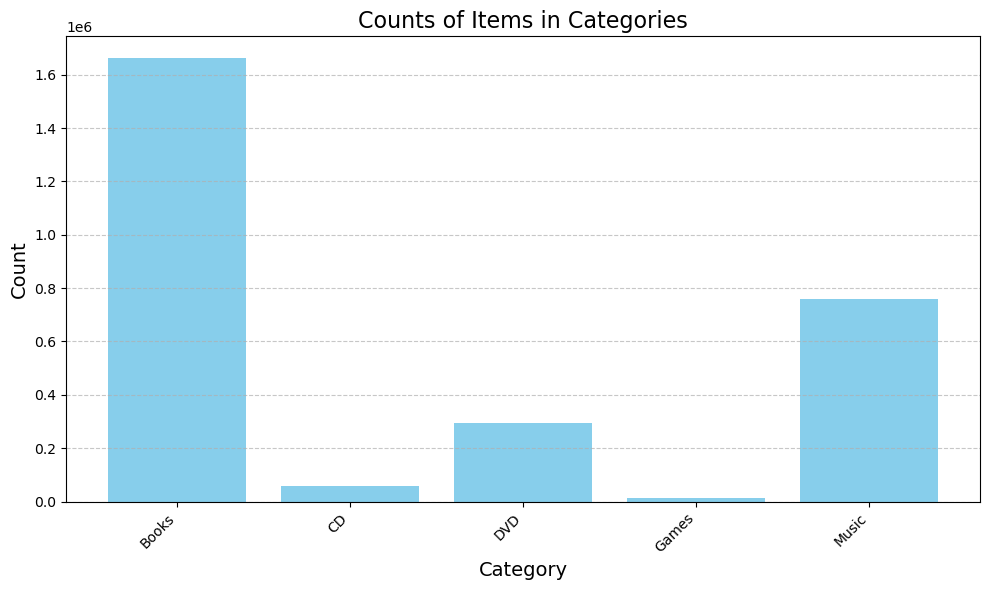

In [3]:
import sqlite3
import matplotlib.pyplot as plt

# Connect to the database
conn = sqlite3.connect("amazon_items.db")
cursor = conn.cursor()

productType = ['Books', 'CD', 'Music', 'DVD', "Games"]
case_clauses = " ".join([f"WHEN CategoryName LIKE '%{word}%' THEN '{word}'" for word in productType])

countQuery = f""" 
SELECT CASE {case_clauses} else 'Other' END AS GroupedCategory,
COUNT(ItemID) AS COUNT FROM Categories
WHERE {" OR ".join([f"CategoryName LIKE '%{word}%'" for word in productType])}
GROUP BY GroupedCategory
"""

params = [f"%{word}%" for word in productType]

#cursor.execute(productQuery)
cursor.execute(countQuery)


result = cursor.fetchall()

for category, count in result:
    print(f"{category}: {count}")

conn.close()

# Extract categories and counts
categories = [row[0] for row in result]
counts = [row[1] for row in result]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color='skyblue')
plt.title('Counts of Items in Categories', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()




In [35]:
import sqlite3
import matplotlib.pyplot as plt

# Connect to the database
conn = sqlite3.connect("amazon_items.db")
cursor = conn.cursor()

productQuery = """
select distinct CategoryName from categories
"""

"""
productQuery = """"""
    select count(ItemID) from categories where CategoryName like "%CD%" group by CategoryName
    """
cursor.execute(productQuery)

category = cursor.fetchall()
for i in category:
    print(i)

('Books',)
('Subjects',)
('Religion & Spirituality',)
('Christianity',)
('Clergy',)
('Preaching',)
('Sermons',)
('Earth-Based Religions',)
('Wicca',)
('Witchcraft',)
('Home & Garden',)
('Crafts & Hobbies',)
('General',)
('Reference',)
('Commentaries',)
('New Testament',)
('Christian Living',)
('Discipleship',)
('Bibles',)
('Translations',)
('Life Application',)
('Bible & Other Sacred Texts',)
('Bible',)
('Study Guides, History & Reference',)
('Worship & Devotion',)
('Prayerbooks',)
('Business',)
('Arts & Photography',)
('Photography',)
('Photo Essays',)
('History',)
('Americas',)
('United States',)
('Jewish',)
('Nonfiction',)
('Social Sciences',)
('Sociology',)
('Urban',)
('',)
('Categories',)
('Camera & Photo',)
('Photography Books',)
('Music',)
('Styles',)
('Jazz',)
('Modern Postbebop',)
('Specialty Stores',)
('Imports',)
('Gay & Lesbian',)
('Crime & Criminals',)
('Criminology',)
('Politics',)
('U.S.',)
('Cooking, Food & Wine',)
('Baking',)
('Bread',)
('Literature & Fiction',)
('Hist